# Deep Convolutional Q-Learning Network

**TODO**: introduction

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym
import gym.spaces

# plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':14,'axes.labelsize':18,'axes.titlesize':18,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)
%matplotlib nbagg

gym.logger.set_level(40)
gym.__version__

'0.10.5'

In [2]:
from keras import __version__ as K_ver
from keras.backend import _config as K_cf
from tensorflow import __version__ as tf_ver
print("Tensorflow version: {}".format(tf_ver))
print("Keras version: {}".format(K_ver))
print("Keras config: \n")
K_cf

/home/mholub/miniconda3/envs/dl36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow version: 1.8.0
Keras version: 2.1.5
Keras config: 



{'floatx': 'float32',
 'epsilon': 1e-07,
 'backend': 'tensorflow',
 'image_data_format': 'channels_last'}

In [21]:
from keras.models import load_model, Sequential, Model
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam #Adagrad, RMSProp
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras import backend as K

def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))


model = Sequential()

model.add(Convolution2D(filters = 32, kernel_size = (8, 8), strides = (4, 4),
                        input_shape = (84,84,4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters = 64, kernel_size = (4, 4), strides = (2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters = 64, kernel_size = (3, 3), strides = (1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
flatten = model.layers[-1].output # get output of the flatten layer

fc1 = Dense(units = 512, activation = None)(flatten)
advantage = Dense(6, activation = None)(fc1)
fc2 = Dense(units = 512, activation = None)(flatten)
value = Dense(1)(fc2)

# dueling_type == 'avg'
# Q(s,a;theta) = V(s;theta) + (A(s,a;theta)-Avg_a(A(s,a;theta)))
policy = Lambda(lambda x: x[0]-K.mean(x[0])+x[1],
                output_shape = (6, ))([advantage, value])

input_layer = model.input
model = Model(inputs = [input_layer], outputs = [policy])
model.compile( loss = ["MSE"], optimizer = Adam(lr = .001),
                            metrics = ["mae", mean_q])

In [6]:
env = gym.make("SpaceInvaders-v0")
print("The actions are: {}".format(env.unwrapped.get_action_meanings()))

The actions are: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [17]:
%load_ext autoreload
%autoreload 2
from space_invaders import SpaceInvader

game = SpaceInvader(max_memory = 10000, num_episodes = 10,target_update_freq = 1000,
                    min_steps_train = 500, epsilon = .75, eps_decay_rate=.9,
                    model_save_freq = 200, model_train_freq = 200)

# game.load_network("./saved_models/spaceinvader_ep1000_DQN_2.h5")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2018-06-10 13:07:48,648:space_invaders:INFO: Environment: SpaceInvaders-v4. There are 6 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_7_input (InputLayer)     (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 20, 20, 32)   6176        conv2d_7_input[0][0]             
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 20, 20, 32)   0           conv2d_7[0][0]                   
_______________________________________________________________

In [18]:
game.main()

2018-06-10 13:07:59,235:space_invaders:INFO: Episode 1/10 finished. Reward: 90.00, Frame # 726.
2018-06-10 13:08:02,512:space_invaders:INFO: Episode 2/10 finished. Reward: 50.00, Frame # 1360.
2018-06-10 13:08:04,779:space_invaders:INFO: Model trained, frame: 1798
2018-06-10 13:08:05,831:space_invaders:INFO: Loss/Metrics on fit: {'loss': 0.23307303, 'mean_absolute_error': 1.3518656, 'mean_q': 0.04176217}
2018-06-10 13:08:09,030:space_invaders:INFO: Model trained, frame: 2398
2018-06-10 13:08:09,367:space_invaders:INFO: Loss/Metrics on fit: {'loss': 27.909859, 'mean_absolute_error': 40.016346, 'mean_q': 61.475376}
2018-06-10 13:08:11,879:space_invaders:INFO: Episode 3/10 finished. Reward: 185.00, Frame # 2878.
2018-06-10 13:08:12,523:space_invaders:INFO: Model trained, frame: 2998
2018-06-10 13:08:12,852:space_invaders:INFO: Loss/Metrics on fit: {'loss': 0.10987302, 'mean_absolute_error': 1.0584736, 'mean_q': 1.7939814}
2018-06-10 13:08:12,868:space_invaders:INFO: Target updated, frame:

In [20]:
game.simulate_()

Lived for 681 frames, total reward was 0.0


In [35]:
import matplotlib.pyplot as plt
import numpy as np
with open("/home/mholub/q_vals.txt", "r") as f:
    q_vals = []
    for line in f:
        q_vals.append(float(line.rstrip()))
plt.close()
plt.plot(q_vals)
plt.savefig("/home/mholub/q_vals.png")

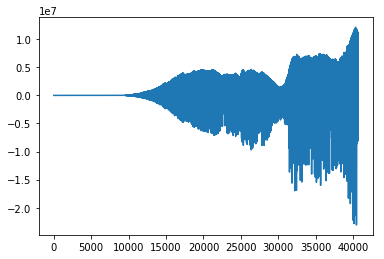

In [17]:
plt.plot(q_vals)

In [7]:
game.plot_()

In [6]:
game.simulate_()

Lived for 667 frames, total reward was 0.0
